## Data extraction from Axiom database 

In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [ ]:

biochem= pd.read_csv("./inputs/merged_biochem.csv")


biochem['compound_name'].unique()


compounds = ["Celecoxib", "Ketoprofen", "Mefenamic acid", "Lumiracoxib", "DMSO", 'Valdecoxib' ]


filtered_df = biochem[biochem["compound_name"].isin(compounds)][["plate", "well", "compound_name", "compound_concentration_um"]]
print(filtered_df["compound_name"].value_counts())


result_tables = {compound: filtered_df[filtered_df["compound_name"] == compound] for compound in compounds}


for compound, df in result_tables.items():
    print(f"Table pour {compound}:")
    print(df)
    print("\n" + "-"*50 + "\n")



df_celecoxib = result_tables["Celecoxib"]
df_ketoprofen = result_tables["Ketoprofen"]
df_mefenamic_acid = result_tables["Mefenamic acid"]
df_lumiracoxib = result_tables["Lumiracoxib"]
df_dmso = result_tables["DMSO"]



df_lumiracoxib['compound_concentration_um'].unique()
df_dmso



plate_id = "plate_41002898" 
df_dmso_filtered = df_dmso[df_dmso["plate"] == plate_id]

print(df_dmso_filtered["well"].tolist())

compound_name
DMSO              4987
Ketoprofen          16
Mefenamic acid      16
Valdecoxib          16
Lumiracoxib         16
Celecoxib           16
Name: count, dtype: int64
Table pour Celecoxib:
                plate well compound_name  compound_concentration_um
3614   plate_41002695  J14     Celecoxib                  11.000000
3936   plate_41002899  J18     Celecoxib                   3.500000
5310   plate_41002702  L15     Celecoxib                   0.045643
6397   plate_41002896   A8     Celecoxib                 100.000000
8265   plate_41002688  J18     Celecoxib                   3.500000
8925   plate_41002700  G17     Celecoxib                  33.500000
9543   plate_41002906   J8     Celecoxib                   1.000000
13346  plate_41002901   F7     Celecoxib                   0.410788
15682  plate_41002693   J8     Celecoxib                 100.000000
16098  plate_41002697   J8     Celecoxib                   1.000000
16452  plate_41002894   I3     Celecoxib            

In [ ]:
### put the name of the compound and it will extract all the data from sqlite files

def format_well(well):
    letter = well[0]
    number = well[1:]
    number = f"{int(number):02d}"
    return f"{letter}{number}"

def process_plate(plate_name, compound, result_tables, output_dir):
    try:
        db_path = f"/Users/grigoryanmariam/Library/Mobile Documents/com~apple~CloudDocs/Documents/thèse/Plates_rep1_2/{plate_name}.sqlite"
        if not os.path.exists(db_path):
            return pd.DataFrame()

        df_cpd = result_tables[compound]
        df_cpd_plate = df_cpd[df_cpd['plate'] == plate_name]
        df_cpd_plate['well'] = df_cpd_plate['well'].apply(format_well)
        wells = df_cpd_plate['well'].unique()

        conn = sqlite3.connect(db_path)
        tables = ["Cells", "Cytoplasm", "Nuclei"]

        well_filters = " OR ".join([f"LOWER(FileName_CellOutlines) LIKE '{well}_%'" for well in wells])
        query_image_filtered = f"""
        SELECT TableNumber, ImageNumber, FileName_CellOutlines
        FROM Image
        WHERE {well_filters}
        """

        df_images = pd.read_sql_query(query_image_filtered, conn)

        for table in tables:
            query = f"""
            SELECT {table}.*, Image_File.FileName_CellOutlines
            FROM {table}
            JOIN ({query_image_filtered}) AS Image_File 
            USING (TableNumber, ImageNumber);
            """
            df = pd.read_sql_query(query, conn)
            output_file = os.path.join(output_dir, f"{table}_filtered_with_filenames_{plate_name}.parquet")
            df.to_parquet(output_file, index=False)

        conn.close()

        df_combined = pd.concat([pd.read_parquet(os.path.join(output_dir, f"{table}_filtered_with_filenames_{plate_name}.parquet")) for table in tables], axis=1)
        df_combined = df_combined.loc[:, ~df_combined.columns.duplicated()]

        df_combined['well'] = df_combined['FileName_CellOutlines'].str.extract(r'(^[A-Z0-9]+)')[0]
        df_combined['well'] = df_combined['well'].apply(format_well)

        df_combined = df_combined.merge(
            df_cpd_plate[['well', 'compound_name', 'compound_concentration_um', 'plate']],
            on='well',
            how='left'
        )

        df_combined['plate'] = df_combined['plate'].fillna('unknown')
        df_combined = df_combined.drop(columns=['TableNumber', 'ImageNumber', 'FileName_CellOutlines'])
        
        return df_combined

    except Exception as e:
        return pd.DataFrame()



compound = "Valdecoxib"
output_dir = "/Users/grigoryanmariam/Downloads"
plate_names = result_tables[compound]['plate']

df_final = pd.concat([process_plate(plate_name, compound, result_tables, output_dir) for plate_name in plate_names])


df_final['plate'] = df_final['plate'].str.extract(r'(\d{4})$')

print(df_final['plate'].nunique())

rep1_plates = ['2695', '2702', '2689', '2701', '2693', '2697', '2699', '2690']

df_final['replicate'] = np.where(df_final['plate'].isin(rep1_plates), '1', '2')

print(df_final.head())

df_final.to_csv("./inputs/Valdecoxib.csv", index=False)



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Données simulées : 1 composé, 8 concentrations, 1 réplicat
concentrations = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
n_classes = 4
n_replicates = 1

# Générer des proportions fictives
np.random.seed(42)
data = []

for conc in concentrations:
    proportions = np.random.dirichlet(alpha=[1.5, 2, 2.5, 1])  # génère 4 proportions qui font 1
    row = {
        'compound': 'Compound_X',
        'concentration': conc,
        'replicate': 1
    }
    for i in range(n_classes):
        row[f'class_{i}'] = proportions[i]
    data.append(row)

df_proportions = pd.DataFrame(data)
print(df_proportions)


     compound  concentration  replicate   class_0   class_1   class_2  \
0  Compound_X           0.01          1  0.250814  0.209447  0.257867   
1  Compound_X           0.03          1  0.222815  0.244820  0.354438   
2  Compound_X           0.10          1  0.031535  0.275088  0.286990   
3  Compound_X           0.30          1  0.019338  0.704890  0.258513   
4  Compound_X           1.00          1  0.097099  0.202862  0.330502   
5  Compound_X           3.00          1  0.067605  0.096477  0.797165   
6  Compound_X          10.00          1  0.338799  0.297693  0.313853   
7  Compound_X          30.00          1  0.214172  0.113776  0.273462   

    class_3  
0  0.281872  
1  0.177928  
2  0.406387  
3  0.017259  
4  0.369537  
5  0.038754  
6  0.049655  
7  0.398590  


In [4]:
print(df_long)

      compound  concentration  replicate    class  proportion
0   Compound_X           0.01          1  class_0    0.250814
1   Compound_X           0.03          1  class_0    0.222815
2   Compound_X           0.10          1  class_0    0.031535
3   Compound_X           0.30          1  class_0    0.019338
4   Compound_X           1.00          1  class_0    0.097099
5   Compound_X           3.00          1  class_0    0.067605
6   Compound_X          10.00          1  class_0    0.338799
7   Compound_X          30.00          1  class_0    0.214172
8   Compound_X           0.01          1  class_1    0.209447
9   Compound_X           0.03          1  class_1    0.244820
10  Compound_X           0.10          1  class_1    0.275088
11  Compound_X           0.30          1  class_1    0.704890
12  Compound_X           1.00          1  class_1    0.202862
13  Compound_X           3.00          1  class_1    0.096477
14  Compound_X          10.00          1  class_1    0.297693
15  Comp

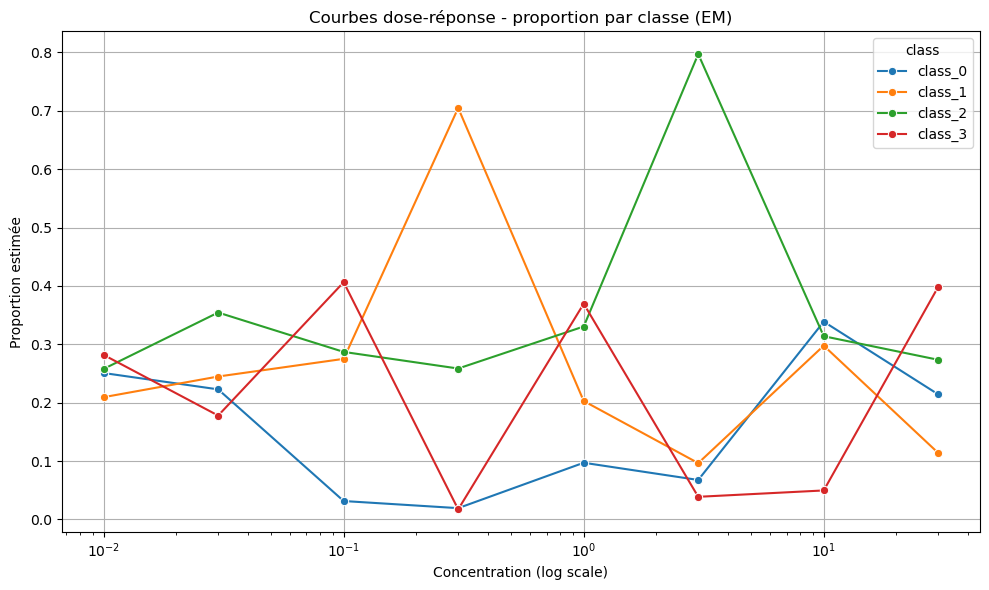

In [3]:
# Passer en format long pour seaborn
df_long = df_proportions.melt(
    id_vars=['compound', 'concentration', 'replicate'],
    value_vars=[f'class_{i}' for i in range(n_classes)],
    var_name='class',
    value_name='proportion'
)

# Tracer les courbes
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='concentration', y='proportion', hue='class', marker='o')
plt.xscale('log')
plt.title("Courbes dose-réponse - proportion par classe (EM)")
plt.xlabel("Concentration (log scale)")
plt.ylabel("Proportion estimée")
plt.grid(True)
plt.tight_layout()
plt.show()
